In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras

In [79]:
path = "./data/" 
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

In [80]:
##conda install keras-gpu 하면 gpu도 괴롭힐 수 있음

## 전처리
 - 이상치 확인 및 처리

In [81]:
train_df.shape

(199991, 22)

In [82]:
train_df.describe()

,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,360.830152,-6.750146e+00,18.675373,18.401235,18.043495,17.663526,1.084986e+01,19.072693,19.134483,18.183331,18.000882,21.837903,18.454136,18.481525,17.686617,17.699207,20.110991,18.544375,18.181544,17.692395,17.189281
std,225.305890,1.187678e+04,155.423024,127.128078,116.622194,123.735298,4.172116e+03,749.256162,90.049058,122.378972,145.862346,789.472333,154.376277,97.240448,145.730872,142.691880,122.299062,161.728183,133.984475,131.183416,133.685138
min,1.000000,-5.310802e+06,-40022.466071,-27184.795793,-26566.310827,-24878.828280,-1.864766e+06,-215882.917191,-21802.656144,-20208.516262,-26505.602101,-24463.431833,-25958.752324,-23948.588523,-40438.184078,-30070.729379,-26236.578659,-36902.402336,-36439.638493,-38969.416822,-26050.710196
25%,174.000000,1.965259e+01,18.701180,18.048572,17.747663,17.425523,1.994040e+01,18.902851,18.259352,17.903615,17.606148,19.247795,18.113933,17.479794,17.050294,16.804705,19.266214,18.076120,17.423425,16.977671,16.705774
50%,349.000000,2.087136e+01,19.904235,19.454492,19.043895,18.611799,2.104910e+01,20.069038,19.631419,19.188763,18.710967,20.366848,19.586559,19.182789,18.693370,18.174592,20.406840,19.547674,19.143156,18.641756,18.100997
75%,526.000000,2.216043e+01,21.150297,20.515936,20.073528,19.883760,2.233754e+01,21.385830,20.773911,20.331419,20.133179,21.797480,21.004397,20.457491,20.019112,19.807652,21.992898,20.962386,20.408140,19.968846,19.819554
max,1000.000000,1.877392e+04,3538.984910,3048.110913,4835.218639,9823.740407,4.870154e+03,248077.513380,12084.735440,8059.638535,18358.921741,298771.019041,12139.815877,7003.136546,9772.190537,17403.789263,14488.251976,10582.058590,12237.951703,4062.499371,7420.534172


In [83]:
def del_outlier(data, min=0, max=60):
    up_idx_t=()
    dw_idx_t=()
    train_light = data.iloc[:,2:]
    for i in range(len(train_light.columns)):
        col = train_light.columns[i]
        up_idx_t+=tuple(data[data[col]>max].index)
        dw_idx_t+=tuple(data[data[col]<min].index)
    del_idx = set(up_idx_t+dw_idx_t)
    
    return data[~data.index.isin(del_idx)]

In [84]:
train_df = del_outlier(train_df, min=-60, max=60)

In [85]:
train_df.columns, train_df.shape

(Index(['type', 'fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
        'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i',
        'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
        'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
        'modelMag_z'],
       dtype='object'), (199805, 22))

## DATA Setting

In [86]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

train_df['type_num'] = train_df['type'].apply(lambda x: to_number(x, column_number))


In [87]:
def add_minus_feature(data,test = False):
    from itertools import combinations
    n = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
        for combi in list(combinations(selected,2)):
            name_1st = str.split(combi[0],'_')[1]
            name_2nd = str.split(combi[1],'_')[1]
            data[mag+"_"+name_1st+"-"+name_2nd] = data[combi[0]]-data[combi[1]]
        n=count
    return data

In [88]:
train_df = add_minus_feature(train_df)
test_df = add_minus_feature(test_df,True)

In [89]:
train_X = train_df.drop(columns=['type', 'type_num'], axis=1)
train_y = train_df['type_num']
test_X = test_df

In [90]:
train_X.head()

,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,...,petroMag_g-i,petroMag_g-z,petroMag_r-i,petroMag_r-z,petroMag_i-z,modelMag_u-g,modelMag_u-r,modelMag_u-i,modelMag_u-z,modelMag_g-r,modelMag_g-i,modelMag_g-z,modelMag_r-i,modelMag_r-z,modelMag_i-z
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,601,23.198224,21.431953,21.314148,21.176553,21.171444,22.581309,21.644453,21.657571,21.387653,21.572827,22.504317,21.431636,21.478312,21.145409,...,0.286226,1.009190,0.332902,1.055866,0.722964,1.283708,1.385054,1.728637,1.601901,0.101347,0.444929,0.318194,0.343582,0.216847,-0.126735
1,788,21.431355,20.708104,20.678850,20.703420,20.473229,21.868797,21.029773,20.967054,20.937731,21.063646,21.360701,20.778968,20.889705,20.639812,...,0.139156,0.132308,0.249893,0.243045,-0.006847,0.734428,0.739030,0.799566,0.980641,0.004602,0.065138,0.246213,0.060537,0.241611,0.181074
2,427,17.851451,16.727898,16.679677,16.694640,16.641788,18.171890,17.033098,16.999682,17.095999,17.076449,17.867253,16.738784,16.688874,16.744210,...,-0.005426,-0.069222,-0.055336,-0.119132,-0.063796,1.120628,1.176814,1.157885,1.129134,0.056186,0.037257,0.008506,-0.018929,-0.047680,-0.028751
3,864,20.789900,20.040371,19.926909,19.843840,19.463270,21.039030,20.317165,20.217898,20.073852,19.794505,20.433907,19.993727,19.985531,19.750917,...,0.242810,0.538610,0.234614,0.530413,0.295800,0.769012,0.880913,1.012598,1.217856,0.111901,0.243586,0.448844,0.131685,0.336943,0.205258
4,612,26.454969,23.058767,21.471406,19.504961,18.389096,25.700632,23.629122,21.742750,19.861718,18.810375,25.859229,22.426929,21.673551,19.610012,...,2.816917,4.050788,2.063539,3.297411,1.233871,1.729059,3.401710,5.389723,6.501398,1.672651,3.660663,4.772338,1.988012,3.099688,1.111675


In [91]:
train_X.columns

Index(['fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z',
       'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i', 'fiberMag_z',
       'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z',
       'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z',
       'psfMag_u-g', 'psfMag_u-r', 'psfMag_u-i', 'psfMag_u-z', 'psfMag_g-r',
       'psfMag_g-i', 'psfMag_g-z', 'psfMag_r-i', 'psfMag_r-z', 'psfMag_i-z',
       'fiberMag_u-g', 'fiberMag_u-r', 'fiberMag_u-i', 'fiberMag_u-z',
       'fiberMag_g-r', 'fiberMag_g-i', 'fiberMag_g-z', 'fiberMag_r-i',
       'fiberMag_r-z', 'fiberMag_i-z', 'petroMag_u-g', 'petroMag_u-r',
       'petroMag_u-i', 'petroMag_u-z', 'petroMag_g-r', 'petroMag_g-i',
       'petroMag_g-z', 'petroMag_r-i', 'petroMag_r-z', 'petroMag_i-z',
       'modelMag_u-g', 'modelMag_u-r', 'modelMag_u-i', 'modelMag_u-z',
       'modelMag_g-r', 'modelMag_g-i', 'modelMag_g-z', 'modelMag_r-i',
       'modelMag_r-z', 'modelMag_i-z'],


In [92]:
## u-g, g-r, r-i, i-z 만 남기는게 좋지 않을까????
train_X.drop(['psfMag_u-r','psfMag_u-i','psfMag_u-z','psfMag_g-i','psfMag_g-z','psfMag_r-z',
             'fiberMag_u-r','fiberMag_u-i','fiberMag_u-z','fiberMag_g-i','fiberMag_g-z','fiberMag_r-z',
             'petroMag_u-r','petroMag_u-i','petroMag_u-z','petroMag_g-i','petroMag_g-z','petroMag_r-z',
             'modelMag_u-r','modelMag_u-i','modelMag_u-z','modelMag_g-i','modelMag_g-z','modelMag_r-z'] ,axis=1, inplace=True)

test_X.drop(['psfMag_u-r','psfMag_u-i','psfMag_u-z','psfMag_g-i','psfMag_g-z','psfMag_r-z',
             'fiberMag_u-r','fiberMag_u-i','fiberMag_u-z','fiberMag_g-i','fiberMag_g-z','fiberMag_r-z',
             'petroMag_u-r','petroMag_u-i','petroMag_u-z','petroMag_g-i','petroMag_g-z','petroMag_r-z',
         'modelMag_u-r','modelMag_u-i','modelMag_u-z','modelMag_g-i','modelMag_g-z','modelMag_r-z'] ,axis=1, inplace=True)

In [93]:
train_X.shape, test_X.shape

((199805, 37), (10009, 37))

In [94]:
train_X.drop('fiberID', axis=1, inplace=True)
test_X.drop('fiberID', axis=1, inplace=True)

In [95]:
train_X.shape, test_X.shape

((199805, 36), (10009, 36))

In [96]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

In [97]:
o_hot = OneHotEncoder()
y_train= o_hot.fit_transform(y_train.values.reshape(-1,1))
y_train = y_train.toarray()

C:\Users\glory\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [98]:
o2_hot = OneHotEncoder()
y_test= o2_hot.fit_transform(y_test.values.reshape(-1,1))
y_test = y_test.toarray()

C:\Users\glory\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [99]:
y_train.shape, y_test.shape

((139863, 19), (59942, 19))

In [100]:
X_train = X_train.values
X_train.shape

(139863, 36)

In [101]:
X_test = X_test.values
X_test.shape

(59942, 36)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import BatchNormalization
model = Sequential()
model.add(Dense(256*3, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(256*2, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(256*1, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(19, activation='softmax'))


from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

## 얼리스타핑
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

##최적모델 기억
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(0.0002), metrics=['accuracy','categorical_crossentropy'])

history=model.fit(X_train, y_train, validation_data=(X_test, y_test) ,batch_size=200, epochs=2000, verbose=1,
                 callbacks=[es, mc])
### validation_data를 쓰면 test 데이터가 따로있을때 직접 넣을 수 있다.
model.evaluate(X_test, y_test)

Train on 139863 samples, validate on 59942 samples
Epoch 1/2000
139863/139863 [==============================] - 14s 103us/step - loss: 1.5215 - accuracy: 0.5002 - categorical_crossentropy: 1.5215 - val_loss: 0.8918 - val_accuracy: 0.6671 - val_categorical_crossentropy: 0.8918
Epoch 2/2000
139863/139863 [==============================] - 14s 97us/step - loss: 0.9244 - accuracy: 0.6677 - categorical_crossentropy: 0.9244 - val_loss: 0.7519 - val_accuracy: 0.7185 - val_categorical_crossentropy: 0.7519
Epoch 3/2000
139863/139863 [==============================] - 14s 98us/step - loss: 0.8425 - accuracy: 0.6914 - categorical_crossentropy: 0.8425 - val_loss: 0.6760 - val_accuracy: 0.7657 - val_categorical_crossentropy: 0.6760
Epoch 4/2000
139863/139863 [==============================] - 14s 98us/step - loss: 0.7980 - accuracy: 0.7055 - categorical_crossentropy: 0.7980 - val_loss: 0.6810 - val_accuracy: 0.7657 - val_categorical_crossentropy: 0.6810
Epoch 5/2000
139863/139863 [================

139863/139863 [==============================] - 13s 93us/step - loss: 0.5460 - accuracy: 0.8033 - categorical_crossentropy: 0.5460 - val_loss: 0.4851 - val_accuracy: 0.8243 - val_categorical_crossentropy: 0.4851
Epoch 37/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.5442 - accuracy: 0.8042 - categorical_crossentropy: 0.5442 - val_loss: 0.4948 - val_accuracy: 0.8184 - val_categorical_crossentropy: 0.4948
Epoch 38/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.5406 - accuracy: 0.8066 - categorical_crossentropy: 0.5406 - val_loss: 0.4731 - val_accuracy: 0.8313 - val_categorical_crossentropy: 0.4731
Epoch 39/2000
139863/139863 [==============================] - 13s 91us/step - loss: 0.5431 - accuracy: 0.8056 - categorical_crossentropy: 0.5431 - val_loss: 0.5732 - val_accuracy: 0.7864 - val_categorical_crossentropy: 0.5732
Epoch 40/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.5377 - accuracy: 0.

139863/139863 [==============================] - 13s 91us/step - loss: 0.4986 - accuracy: 0.8201 - categorical_crossentropy: 0.4986 - val_loss: 0.4449 - val_accuracy: 0.8375 - val_categorical_crossentropy: 0.4449
Epoch 73/2000
139863/139863 [==============================] - 13s 92us/step - loss: 0.4960 - accuracy: 0.8226 - categorical_crossentropy: 0.4960 - val_loss: 0.4466 - val_accuracy: 0.8406 - val_categorical_crossentropy: 0.4466
Epoch 74/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.5032 - accuracy: 0.8197 - categorical_crossentropy: 0.5032 - val_loss: 0.4370 - val_accuracy: 0.8443 - val_categorical_crossentropy: 0.4370
Epoch 75/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.4946 - accuracy: 0.8232 - categorical_crossentropy: 0.4946 - val_loss: 0.5313 - val_accuracy: 0.7976 - val_categorical_crossentropy: 0.5313
Epoch 76/2000
139863/139863 [==============================] - 13s 91us/step - loss: 0.4970 - accuracy: 0.

139863/139863 [==============================] - 13s 90us/step - loss: 0.4734 - accuracy: 0.8295 - categorical_crossentropy: 0.4734 - val_loss: 0.4230 - val_accuracy: 0.8502 - val_categorical_crossentropy: 0.4230
Epoch 109/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.4727 - accuracy: 0.8299 - categorical_crossentropy: 0.4727 - val_loss: 0.4176 - val_accuracy: 0.8516 - val_categorical_crossentropy: 0.4176
Epoch 110/2000
139863/139863 [==============================] - 13s 92us/step - loss: 0.4793 - accuracy: 0.8273 - categorical_crossentropy: 0.4793 - val_loss: 0.6034 - val_accuracy: 0.7749 - val_categorical_crossentropy: 0.6034
Epoch 111/2000
139863/139863 [==============================] - 13s 91us/step - loss: 0.4755 - accuracy: 0.8283 - categorical_crossentropy: 0.4755 - val_loss: 0.4384 - val_accuracy: 0.8401 - val_categorical_crossentropy: 0.4384
Epoch 112/2000
139863/139863 [==============================] - 13s 91us/step - loss: 0.4703 - accuracy

Epoch 144/2000
139863/139863 [==============================] - 13s 91us/step - loss: 0.4655 - accuracy: 0.8327 - categorical_crossentropy: 0.4655 - val_loss: 0.4341 - val_accuracy: 0.8431 - val_categorical_crossentropy: 0.4341
Epoch 145/2000
139863/139863 [==============================] - 13s 91us/step - loss: 0.4660 - accuracy: 0.8321 - categorical_crossentropy: 0.4660 - val_loss: 0.4247 - val_accuracy: 0.8474 - val_categorical_crossentropy: 0.4247
Epoch 146/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.4614 - accuracy: 0.8348 - categorical_crossentropy: 0.4614 - val_loss: 0.4225 - val_accuracy: 0.8488 - val_categorical_crossentropy: 0.4225
Epoch 147/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.4562 - accuracy: 0.8358 - categorical_crossentropy: 0.4562 - val_loss: 0.4116 - val_accuracy: 0.8517 - val_categorical_crossentropy: 0.4116
Epoch 148/2000
139863/139863 [==============================] - 13s 91us/step - loss: 0.

Epoch 180/2000
139863/139863 [==============================] - 13s 91us/step - loss: 0.4515 - accuracy: 0.8377 - categorical_crossentropy: 0.4515 - val_loss: 0.4960 - val_accuracy: 0.8165 - val_categorical_crossentropy: 0.4960
Epoch 181/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.4515 - accuracy: 0.8380 - categorical_crossentropy: 0.4515 - val_loss: 0.4336 - val_accuracy: 0.8425 - val_categorical_crossentropy: 0.4336
Epoch 182/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.4455 - accuracy: 0.8405 - categorical_crossentropy: 0.4455 - val_loss: 0.4609 - val_accuracy: 0.8324 - val_categorical_crossentropy: 0.4609
Epoch 183/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.4500 - accuracy: 0.8386 - categorical_crossentropy: 0.4500 - val_loss: 0.4122 - val_accuracy: 0.8521 - val_categorical_crossentropy: 0.4122
Epoch 184/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.

Epoch 216/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.4422 - accuracy: 0.8404 - categorical_crossentropy: 0.4422 - val_loss: 0.4224 - val_accuracy: 0.8497 - val_categorical_crossentropy: 0.4224
Epoch 217/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.4435 - accuracy: 0.8397 - categorical_crossentropy: 0.4435 - val_loss: 0.4109 - val_accuracy: 0.8527 - val_categorical_crossentropy: 0.4109
Epoch 218/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.4443 - accuracy: 0.8405 - categorical_crossentropy: 0.4443 - val_loss: 0.4632 - val_accuracy: 0.8237 - val_categorical_crossentropy: 0.4632
Epoch 219/2000
139863/139863 [==============================] - 13s 91us/step - loss: 0.4397 - accuracy: 0.8412 - categorical_crossentropy: 0.4397 - val_loss: 0.5663 - val_accuracy: 0.7817 - val_categorical_crossentropy: 0.5663
Epoch 220/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.

Epoch 252/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.4369 - accuracy: 0.8432 - categorical_crossentropy: 0.4369 - val_loss: 0.4074 - val_accuracy: 0.8550 - val_categorical_crossentropy: 0.4074
Epoch 253/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.4335 - accuracy: 0.8441 - categorical_crossentropy: 0.4335 - val_loss: 0.4021 - val_accuracy: 0.8575 - val_categorical_crossentropy: 0.4021
Epoch 254/2000
139863/139863 [==============================] - 13s 91us/step - loss: 0.4394 - accuracy: 0.8416 - categorical_crossentropy: 0.4394 - val_loss: 0.4016 - val_accuracy: 0.8551 - val_categorical_crossentropy: 0.4016
Epoch 255/2000
139863/139863 [==============================] - 13s 91us/step - loss: 0.4379 - accuracy: 0.8424 - categorical_crossentropy: 0.4379 - val_loss: 0.4143 - val_accuracy: 0.8520 - val_categorical_crossentropy: 0.4143
Epoch 256/2000
139863/139863 [==============================] - 13s 92us/step - loss: 0.

Epoch 288/2000
139863/139863 [==============================] - 13s 91us/step - loss: 0.4298 - accuracy: 0.8448 - categorical_crossentropy: 0.4298 - val_loss: 0.4453 - val_accuracy: 0.8375 - val_categorical_crossentropy: 0.4453
Epoch 289/2000
139863/139863 [==============================] - 13s 91us/step - loss: 0.4341 - accuracy: 0.8442 - categorical_crossentropy: 0.4341 - val_loss: 0.4013 - val_accuracy: 0.8566 - val_categorical_crossentropy: 0.4013
Epoch 290/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.4301 - accuracy: 0.8458 - categorical_crossentropy: 0.4301 - val_loss: 0.4436 - val_accuracy: 0.8390 - val_categorical_crossentropy: 0.4436
Epoch 291/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.4326 - accuracy: 0.8440 - categorical_crossentropy: 0.4326 - val_loss: 0.4085 - val_accuracy: 0.8551 - val_categorical_crossentropy: 0.4085
Epoch 292/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.

Epoch 324/2000
139863/139863 [==============================] - 14s 97us/step - loss: 0.4245 - accuracy: 0.8474 - categorical_crossentropy: 0.4245 - val_loss: 0.3947 - val_accuracy: 0.8593 - val_categorical_crossentropy: 0.3947
Epoch 325/2000
139863/139863 [==============================] - 13s 93us/step - loss: 0.4243 - accuracy: 0.8469 - categorical_crossentropy: 0.4243 - val_loss: 0.3884 - val_accuracy: 0.8635 - val_categorical_crossentropy: 0.3884
Epoch 326/2000
139863/139863 [==============================] - 13s 94us/step - loss: 0.4238 - accuracy: 0.8479 - categorical_crossentropy: 0.4238 - val_loss: 0.4249 - val_accuracy: 0.8479 - val_categorical_crossentropy: 0.4249
Epoch 327/2000
139863/139863 [==============================] - 13s 92us/step - loss: 0.4266 - accuracy: 0.8469 - categorical_crossentropy: 0.4266 - val_loss: 0.3949 - val_accuracy: 0.8616 - val_categorical_crossentropy: 0.3949racy: 0.8464 - categorical_crossentro - ETA: 3s - loss: 0.42
Epoch 328/2000
139863/139863

Epoch 360/2000
139863/139863 [==============================] - 14s 99us/step - loss: 0.4212 - accuracy: 0.8490 - categorical_crossentropy: 0.4212 - val_loss: 0.4035 - val_accuracy: 0.8576 - val_categorical_crossentropy: 0.4035
Epoch 361/2000
139863/139863 [==============================] - 13s 95us/step - loss: 0.4264 - accuracy: 0.8466 - categorical_crossentropy: 0.4264 - val_loss: 0.3920 - val_accuracy: 0.8628 - val_categorical_crossentropy: 0.3920
Epoch 362/2000
139863/139863 [==============================] - 13s 95us/step - loss: 0.4226 - accuracy: 0.8487 - categorical_crossentropy: 0.4226 - val_loss: 0.4022 - val_accuracy: 0.8572 - val_categorical_crossentropy: 0.4022
Epoch 363/2000
139863/139863 [==============================] - 13s 96us/step - loss: 0.4225 - accuracy: 0.8475 - categorical_crossentropy: 0.4225 - val_loss: 0.4059 - val_accuracy: 0.8570 - val_categorical_crossentropy: 0.4059
Epoch 364/2000
139863/139863 [==============================] - 13s 95us/step - loss: 0.

Epoch 396/2000
139863/139863 [==============================] - 13s 92us/step - loss: 0.4205 - accuracy: 0.8491 - categorical_crossentropy: 0.4205 - val_loss: 0.3943 - val_accuracy: 0.8611 - val_categorical_crossentropy: 0.3943
Epoch 397/2000
139863/139863 [==============================] - 13s 95us/step - loss: 0.4183 - accuracy: 0.8494 - categorical_crossentropy: 0.4183 - val_loss: 0.3981 - val_accuracy: 0.8586 - val_categorical_crossentropy: 0.3981
Epoch 398/2000
139863/139863 [==============================] - 13s 95us/step - loss: 0.4144 - accuracy: 0.8507 - categorical_crossentropy: 0.4144 - val_loss: 0.4229 - val_accuracy: 0.8480 - val_categorical_crossentropy: 0.4229
Epoch 399/2000
139863/139863 [==============================] - 13s 94us/step - loss: 0.4232 - accuracy: 0.8474 - categorical_crossentropy: 0.4232 - val_loss: 0.4055 - val_accuracy: 0.8595 - val_categorical_crossentropy: 0.4055
Epoch 400/2000
139863/139863 [==============================] - 13s 93us/step - loss: 0.

Epoch 432/2000
139863/139863 [==============================] - 13s 92us/step - loss: 0.4141 - accuracy: 0.8505 - categorical_crossentropy: 0.4141 - val_loss: 0.4346 - val_accuracy: 0.8369 - val_categorical_crossentropy: 0.4346
Epoch 433/2000
139863/139863 [==============================] - 13s 93us/step - loss: 0.4119 - accuracy: 0.8522 - categorical_crossentropy: 0.4119 - val_loss: 0.4204 - val_accuracy: 0.8489 - val_categorical_crossentropy: 0.4204
Epoch 434/2000
139863/139863 [==============================] - 13s 96us/step - loss: 0.4153 - accuracy: 0.8501 - categorical_crossentropy: 0.4153 - val_loss: 0.3957 - val_accuracy: 0.8624 - val_categorical_crossentropy: 0.3957
Epoch 435/2000
139863/139863 [==============================] - 13s 92us/step - loss: 0.4153 - accuracy: 0.8504 - categorical_crossentropy: 0.4153 - val_loss: 0.4148 - val_accuracy: 0.8526 - val_categorical_crossentropy: 0.4148
Epoch 436/2000
139863/139863 [==============================] - 13s 92us/step - loss: 0.

Epoch 468/2000
139863/139863 [==============================] - 13s 90us/step - loss: 0.4161 - accuracy: 0.8496 - categorical_crossentropy: 0.4161 - val_loss: 0.3951 - val_accuracy: 0.8592 - val_categorical_crossentropy: 0.3951
Epoch 469/2000
139863/139863 [==============================] - 13s 91us/step - loss: 0.4142 - accuracy: 0.8508 - categorical_crossentropy: 0.4142 - val_loss: 0.3902 - val_accuracy: 0.8625 - val_categorical_crossentropy: 0.3902
Epoch 470/2000
139863/139863 [==============================] - 13s 92us/step - loss: 0.4123 - accuracy: 0.8519 - categorical_crossentropy: 0.4123 - val_loss: 0.3988 - val_accuracy: 0.8617 - val_categorical_crossentropy: 0.3988
Epoch 471/2000
139863/139863 [==============================] - 13s 92us/step - loss: 0.4171 - accuracy: 0.8498 - categorical_crossentropy: 0.4171 - val_loss: 0.3899 - val_accuracy: 0.8631 - val_categorical_crossentropy: 0.3899
Epoch 472/2000
139863/139863 [==============================] - 13s 92us/step - loss: 0.

In [ ]:
### 최적 모델 불러오기
best_model = keras.models.load_model('best_model.h5')
val_loss, val_acc, val_category = best_model.evaluate(X_test, y_test)

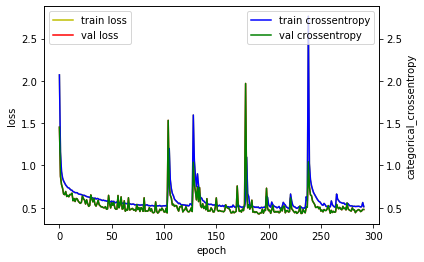

In [46]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['categorical_crossentropy'], 'b', label='train crossentropy')
acc_ax.plot(history.history['val_categorical_crossentropy'], 'g', label='val crossentropy')
acc_ax.set_ylabel('categorical_crossentropy')
acc_ax.legend(loc='upper right')

plt.show()

In [47]:
real_y_pred = best_model.predict(test_X)

In [48]:
submission = pd.DataFrame(data=real_y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv('submission_keras_renewal_0.47970531216167617.csv', index=True)

In [ ]:
### 기록 1.레이어 2. 옴티마이저  ==> val_loss
#1. 9개,// 2. 0.0003 ==> 0.404
#1. 8개(256*2)층 하나 제거 //2. 0.0001 ==> 0.666179819053121
#1. 8개 //2. 0.0005 ==> 
#1. 